## Visualize Reexplore Training Results
Takes in a job directory and output bbox and segm AP curves for all settings 
(class, instance, gtfixed, pfixed)

visualizing results for 17 trajectories ...
visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/36


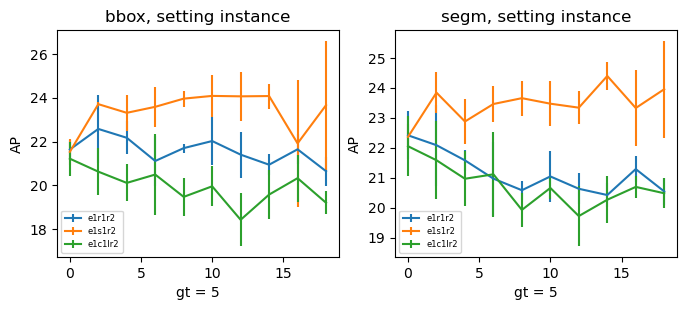

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/36
with GT


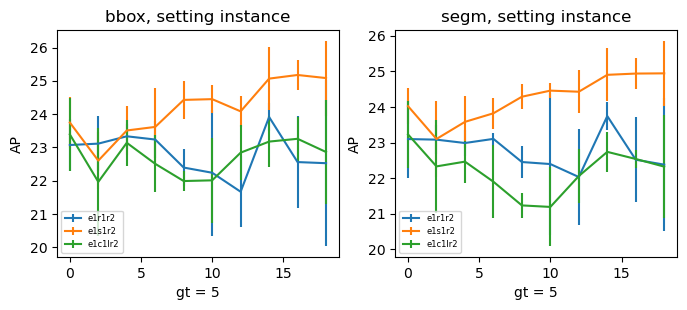

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/16


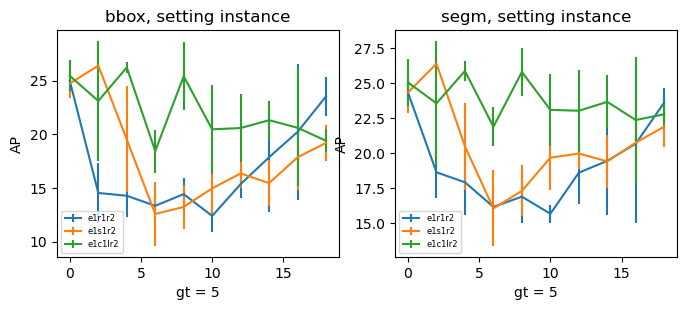

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/16
with GT


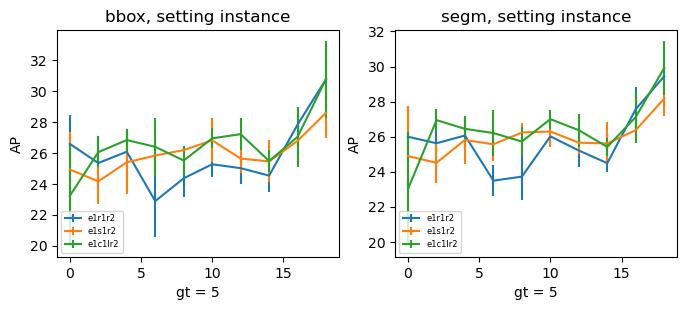

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/10


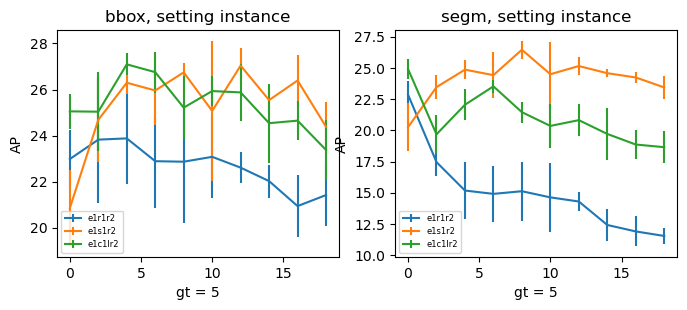

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/10
with GT


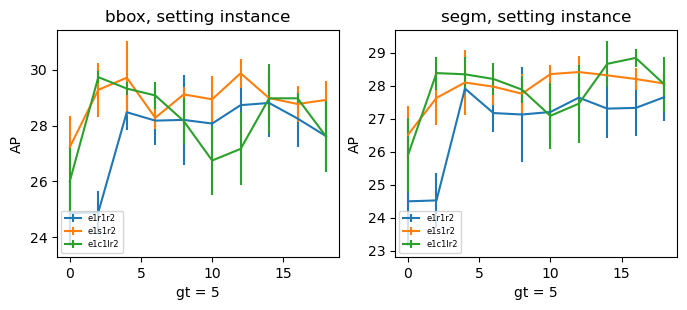

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/0


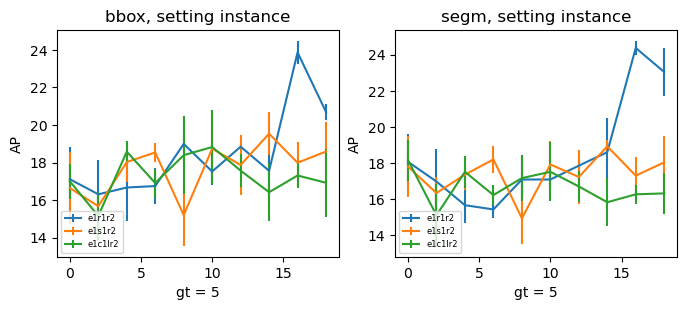

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/0
with GT


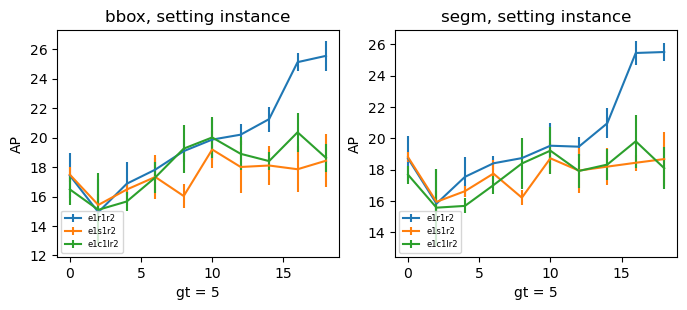

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/22


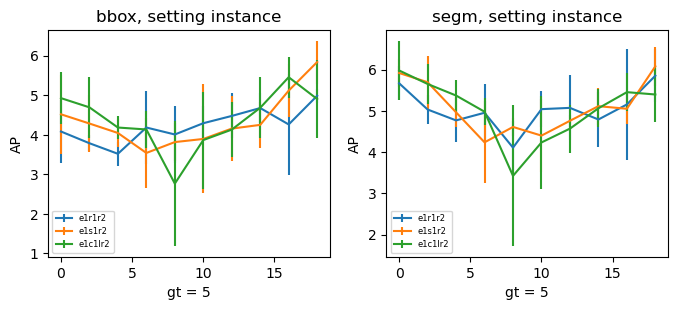

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/22
with GT


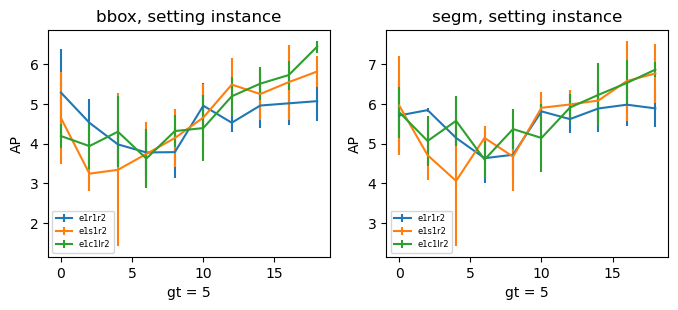

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/8


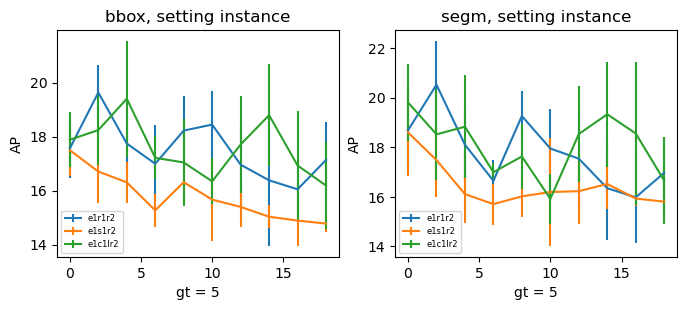

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/8
with GT


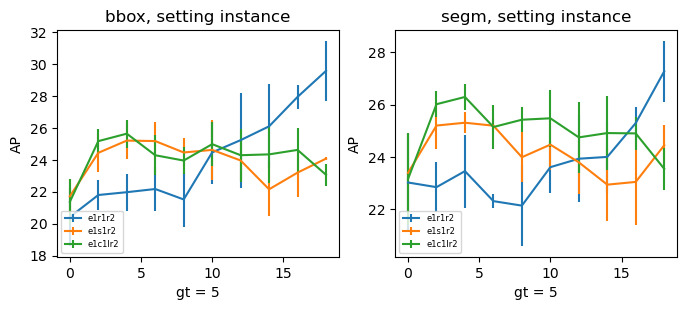

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/60


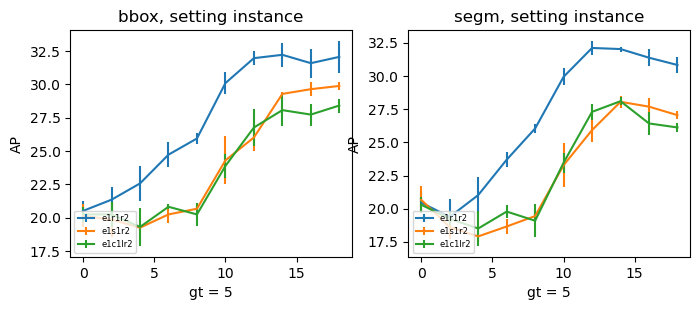

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/60
with GT


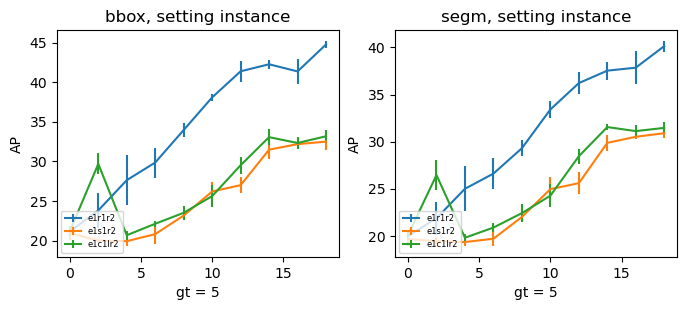

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/2


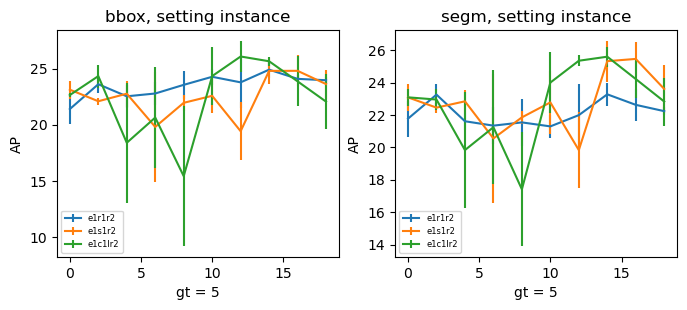

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/2
with GT


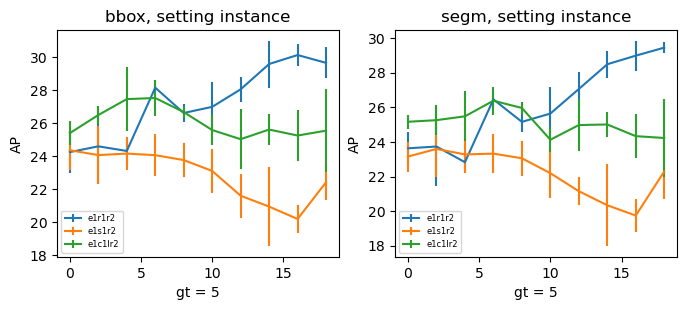

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/28


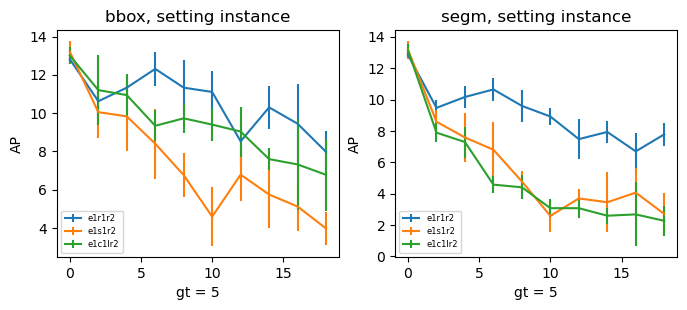

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/28
with GT


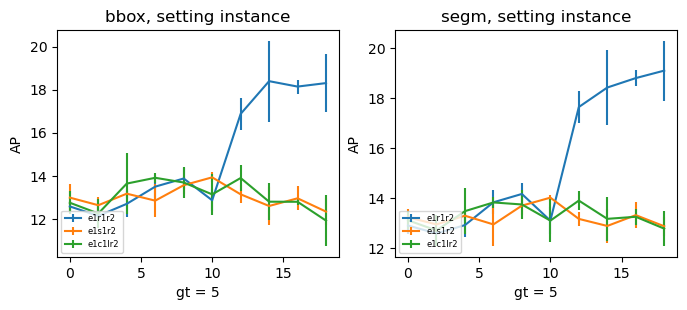

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/50


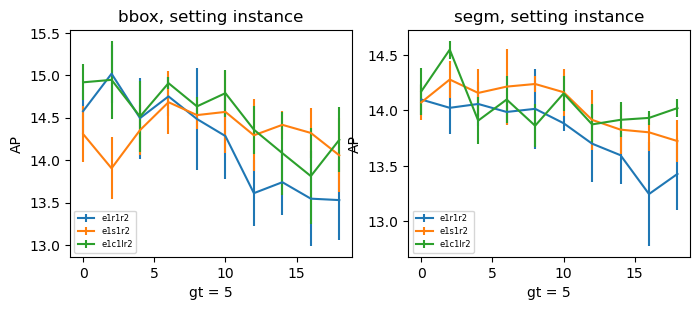

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/50
with GT


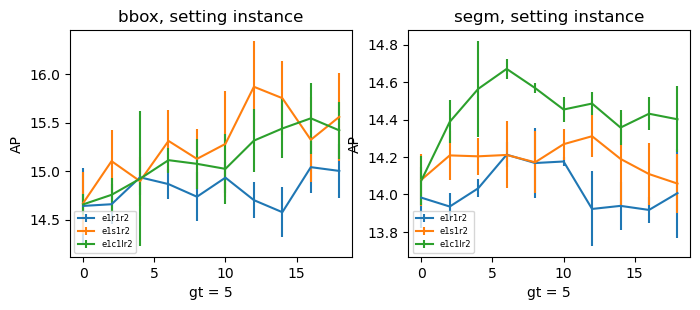

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/69


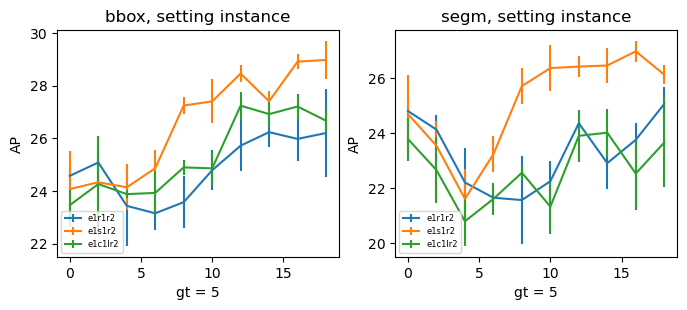

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/69
with GT


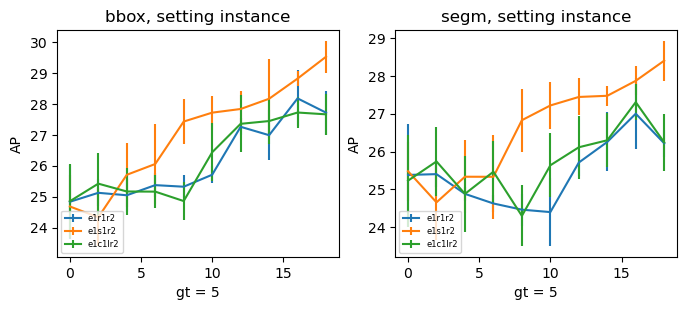

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/39


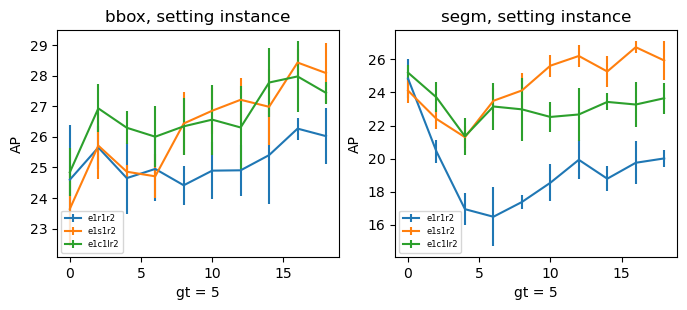

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/39
with GT


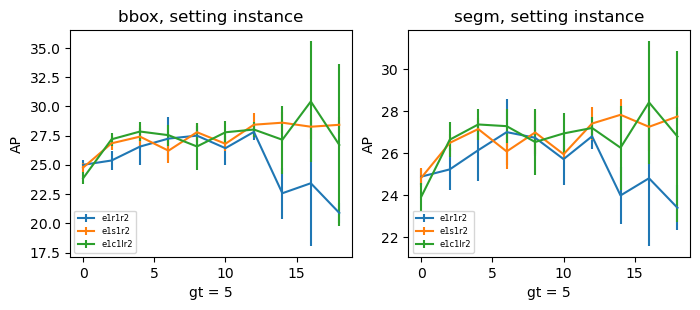

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/41


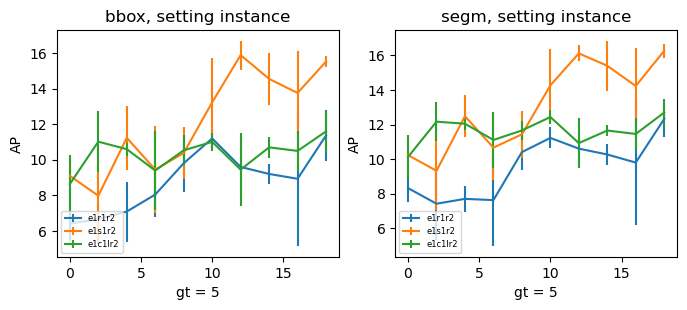

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/41
with GT


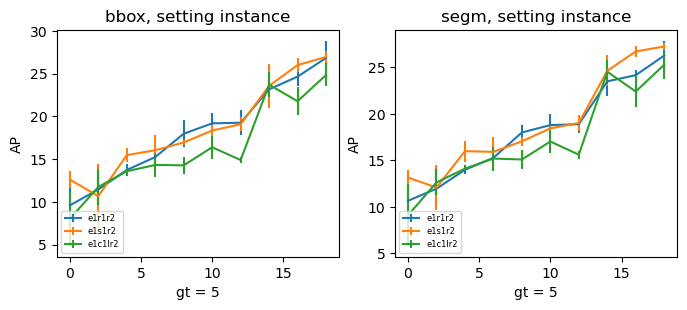

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/48


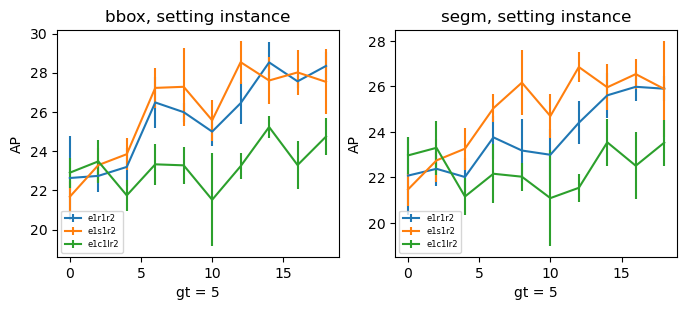

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/48
with GT


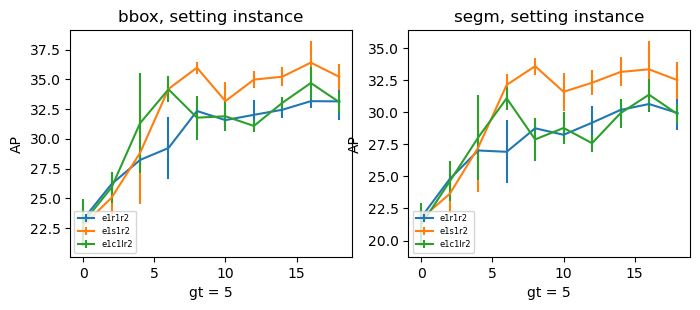

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/62


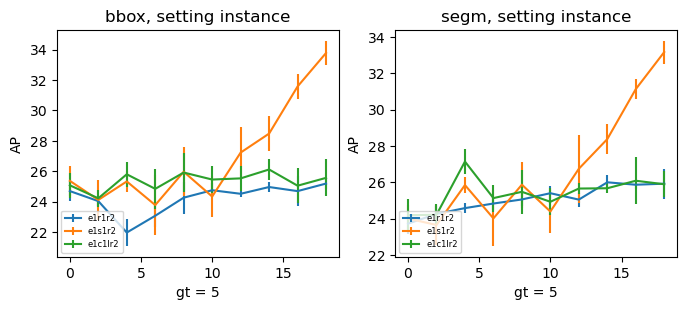

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05/62
with GT


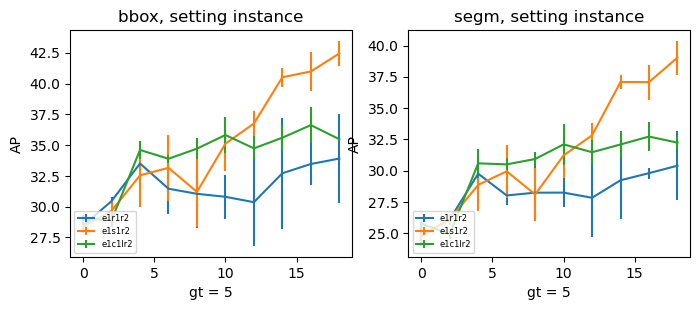

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05


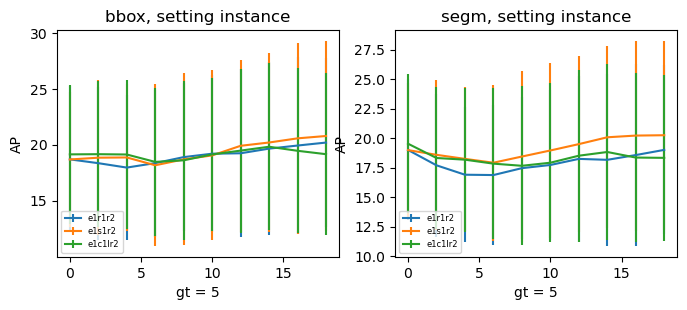

In [18]:
import glob
import json
import os
from typing import Union
from collections import namedtuple, defaultdict
import numpy as np
import matplotlib.pyplot as plt 
from math import sqrt

AP = namedtuple('AP', 'bbox, segm')
# heuristics = ['e1r1r2', 'e1s1r2', 'e1c1lr2']

def load_json(json_path):
    lines = []
    # print(f'looking at {json_path}')
    with open(json_path, 'r') as f:
        ls = f.readlines()
        for line in ls:
            try:
                lines.append(json.loads(line))
            except json.JSONDecodeError:
                print(f'JSONDecodeError {len(line), line[:2]}')
                continue
    return lines

def get_heuristic_gt_p(j, setting, with_gt):
    j = j.split('/')
    gt = j[j.index(setting)+1]
    heu = j[j.index(setting)+2]
    pred_label = j[j.index(setting)+3]
    p = pred_label[pred_label.find('pred_label_p') + len('pred_label_p'):-(len('_with_gt') if with_gt else 1)]
    return heu, gt, p

def get_best_ap(train_dir):
    """
    has metrics for each hyperparam set. 
    find lowest validation loss, and take corresponding training AP.
    """
    def get_ap(l):
        ap_bbox, ap_segm = None, None
        prefix = '_val' #if setting == 'instance' else '_test'
        for k, v in l.items():
            if k.endswith(f'{prefix}/bbox/AP'):
                # print(k)
                ap_bbox = l[k]
            if k.endswith(f'{prefix}/segm/AP'):
                # print(k)
                ap_segm = l[k]
        # print(f'get_ap {ap_bbox, ap_segm}')
        return AP(ap_bbox, ap_segm)            

    def process_json(j):
        x = load_json(m)
        best_val, best_ap = float('inf'), AP(0, 0)
        best_iter = 0
        for l in x:
            if 'validation_loss' in l:
                val_loss = l['validation_loss']
                if val_loss < best_val:
                    best_val = val_loss
                    best_iter = l['iteration']
                    ap = get_ap(l)
                    if ap.bbox is not None and ap.segm is not None:
                        best_ap = ap
        return best_val, best_ap, best_iter
    
    metric_jsons = glob.glob(train_dir + '/**/metrics.json', recursive=True)        

    # Group json by hyperparms
    def group_by(jsons):
        mj = defaultdict(list)
        for j in jsons:
            js = j.split('/')
            
            def extract_heu_idx(js):
                for h in heuristics:
                    if h in js:
                        return js.index(h)
                return -1
            
            tix = extract_heu_idx(js)
            key = '_'.join(js[tix: tix+6])
            mj[key].append(j)
        return mj

    metric_jsons = group_by(metric_jsons)
    # print(f'printing {len(metric_jsons)} metric_json')
    # for m, v in metric_jsons.items():
    #     print(f'\nkey {m}')
    #     for vv in v:
    #           print(f'value {vv}')

    best_val, best_test_ap = float('inf'), AP(0,0)
    best_mjson = None

    for k, v in metric_jsons.items():
        # process all jsons for this hyperparam set
        val_losses, test_aps = [], []
        for m in v:
            val_loss, test_ap, best_iter = process_json(m)
            val_losses.append(val_loss)
            test_aps.append(test_ap)
        val_avg = np.average(val_losses)
        test_avg = AP(np.average([p.bbox for p in test_aps]), np.average([p.segm for p in test_aps]))
        # print(f'\ntrain_dir {train_dir}\nhyperparams {k}, val_losses {val_losses}, test_aps {test_aps}')
        # print(f'val_avg {val_avg}, test_avg {test_avg}, val_min {np.min(val_losses)}')
        if val_avg < best_val:
            best_val = val_avg
            # best_test_ap = test_avg
            best_test_ap = test_aps
            best_mjson = k

    # for m in metric_jsons:
    #     val_ap, test_ap, it = process_json(m)
    #     if val_ap < best_val:
    #         best_test_ap = test_ap 
    #         best_val = val_ap
    #         best_mjson = m
    #     # print(f'metric_json {m}, val_ap {val_ap}, test_ap {test_ap}')

    # print(f'train_dir {train_dir}\nbest val {best_val}, best iter {best_iter} best_ap {best_test_ap}\nbest mjson {best_mjson}\n')
    # print(best_val, best_test_ap)
    return best_test_ap

def process(j: str, setting, with_gt) -> Union[str, int, int, float]:
    # print(j)
    heu, gt, p = get_heuristic_gt_p(j, setting, with_gt)
    # print(heu, gt, p)

    #get best AP- this is not per json, but per pre_label_p0
    ap = get_best_ap(j)
    return heu, gt, p, ap

def visualize(job_dir, setting, with_gt=False):
    """
    visualize setting - gt fixed, p fixed
    draws as many lines as there are heuristic combinations 
    """
    print(f'visualize {job_dir}')
    train_dirs = glob.glob(job_dir + '/**/training', recursive=True)
    
    tdirs = [x for x in train_dirs if setting in x]
    # print(f'{len(tdirs), tdirs[:2]} training directories')
    
    all_scores = defaultdict(list)
        
    # convert each json to <gt, p, best train AP>
    def is_eligible(t):
        if with_gt:
            return '_with_gt' in t
        return '_with_gt' not in t
        
    for t in tdirs:
        if is_eligible(t):
            heu, gt, p, ap = process(t, setting, with_gt)
            # print(heu, gt, p, ap, t)
            all_scores['_'.join([heu, gt, p])].append(ap)   
            # make a dataframe? to keep all these rows?
            # keep dict of heu, gt, p -> list of aps. then plot each heu separately
    
    def pprint(d):
        for k, v in d.items():
            for h in heuristics:
                if h in k:
                    print(k, v)
    
    # pprint(all_scores)
    
    def get_values(h, gt, p):
        key = '_'.join([h, str(gt), str(p)])
        if key in all_scores:
            aps = all_scores[key]
            aps = [x for y in aps for x in y]
            try:
                avg = AP(np.average([p.bbox for p in aps]), np.average([p.segm for p in aps]))
                var = AP(np.var([p.bbox for p in aps]), np.var([p.segm for p in aps]))
            except Exception as ex:
                print(f'key {key} aps {aps}')
                return None, None
            # print(aps, avg, var)
            return avg, var
        
        return None, None
    
    def draw(heu, xs, ys_bbox, ys_bb_err, ys_segm, ys_se_err, ax1, ax2, xlabel):
        # print(f'len xs {len(xs)}, len ys {len(ys_bbox), len(ys_segm)}')
        # print(f'ys_bb_err {ys_bb_err}, ys_se_err {ys_se_err}')
        ax1.set_title(f'bbox, setting {setting}')
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel('AP')
        ax1.errorbar(xs, ys_bbox, yerr=ys_bb_err, label=heu)
        ax1.legend(loc="lower left", prop={'size':6})
        # ax1.set_ylim(ymin=0)

        ax2.set_title(f'segm, setting {setting}')
        ax2.set_xlabel(xlabel)
        ax2.set_ylabel('AP')
        ax2.errorbar(xs, ys_segm, yerr=ys_se_err, label=heu)
        # ax2.set_ylim(ymin=0)

        ax2.legend(loc="lower left", prop={'size':6})

    
    def plot(gts, ps):
        # for each heuristic, plot gt, p
        if len(gts) == 1:
            # ps are the x-values
            # ap are the y-values 
            # xs = ps
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), dpi=100)
            for h in heuristics:
                xs, ys_bb, ys_bb_err, ys_se, ys_se_err = [], [], [], [], []
                for p in ps:
                    y_ap, y_err = get_values(h, gts[0], p)
                    if y_ap is not None:
                        xs.append(p)
                        ys_bb.append(y_ap.bbox)
                        ys_bb_err.append(sqrt(y_err.bbox))
                        ys_se.append(y_ap.segm)
                        ys_se_err.append(sqrt(y_err.segm))
                
                if len(ys_bb) > 0 and len(ys_se) > 0:
                    draw(h, xs, ys_bb, ys_bb_err, ys_se, ys_se_err, ax1, ax2, f'gt = {gts[0]}')
            plt.show()
            
        if len(ps) == 1:
            # gts are the x-values
            # ap are the y-values 
            xs = gts
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), dpi=100)
            for h in heuristics:
                ys_bb, ys_bb_err, ys_se, ys_se_err = [], [], [], []
                for gt in gts:
                    y_ap, y_err = get_values(h, gt, ps[0])
                    if y_ap is not None:
                        ys_bb.append(y_ap.bbox)
                        ys_bb_err.append(sqrt(y_err.bbox))
                        ys_se.append(y_ap.segm)
                        ys_se_err.append(sqrt(y_err.segm))
                
                if len(ys_bb) > 0 and len(ys_se) > 0:
                    draw(h, xs, ys_bb, ys_bb_err, ys_se, ys_se_err, ax1, ax2, 'p fixed')
            plt.show()
    
    if with_gt:
        print(f'with GT')
    plot(gts=[5], ps=range(0,20,2))
    # plot(gts=[10], ps=range(0,20,2))

    # plot(gts=[10], ps=[0,2,4,6,8])

    # plot(gts=[5,10,15], ps=[2])

heuristics = [
    'e1r1r2',
    'e1s1r2', 
    # 'e1c1sr2', 
    'e1c1lr2', 
    # 'e1s1c1s', 
    # 'e1s1c1l', 
]

train_dir = '/checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05' # 4/22 run with 17 trajectories
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/26-04-2022/10:36:46' # 4/26 run with 12 trajectories

print(f'visualizing results for {len(os.listdir(train_dir))} trajectories ...')
for x in os.listdir(train_dir):
    if x.isdigit():
        visualize(os.path.join(train_dir, x), 'instance')
        visualize(os.path.join(train_dir, x), 'instance', with_gt=True)
        
visualize(train_dir, 'instance')
# visualize(train_dir, 'instance', with_gt=True)

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/01:26:45/


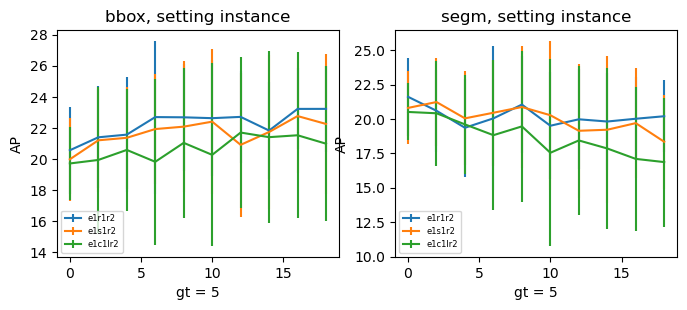

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/01:26:45/0


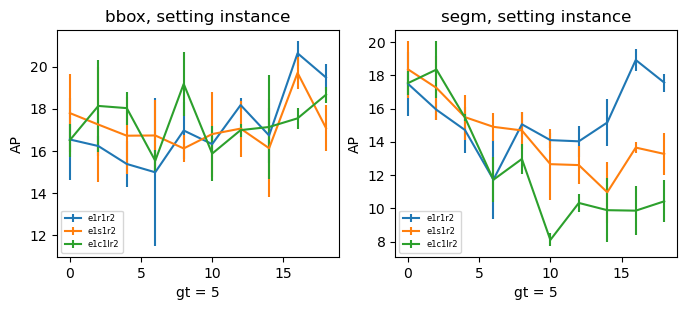

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/01:26:45/22


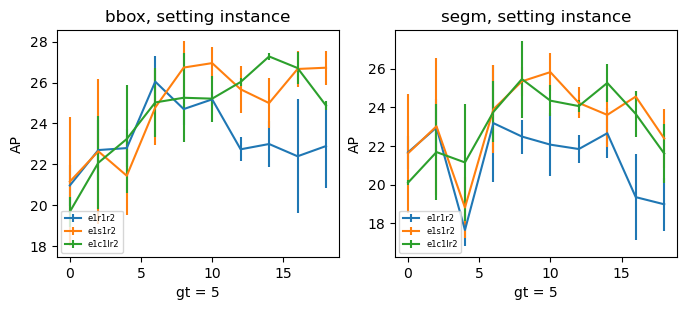

visualize /checkpoint/apratik/jobs/reexplore/training/22-04-2022/01:26:45/25


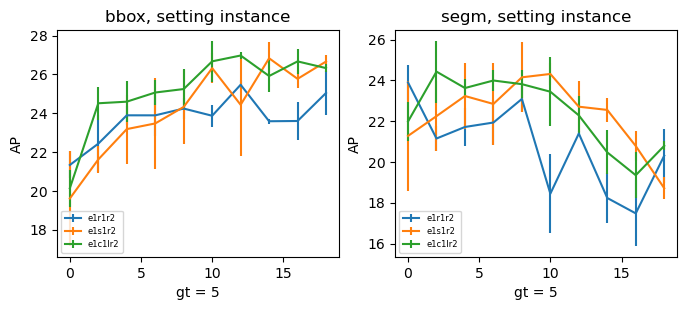

In [31]:
# visualize('/checkpoint/apratik/jobs/reexplore/training/04-04-2022/12:52:05', 'instance') # with gt
# # visualize('/checkpoint/apratik/jobs/reexplore/training/14-04-2022/12:02:26/0', 'instance') # with depth filter
# visualize('/checkpoint/apratik/jobs/reexplore/training/14-04-2022/12:02:26/2', 'instance')
# visualize('/checkpoint/apratik/jobs/reexplore/training/14-04-2022/12:02:26/6', 'instance')
# visualize('/checkpoint/apratik/jobs/reexplore/training/14-04-2022/12:02:26/8', 'instance')

# visualize('/checkpoint/apratik/jobs/reexplore/training/14-04-2022/23:19:24/2', 'instance') # depth filter + hole filling
# visualize('/checkpoint/apratik/jobs/reexplore/training/14-04-2022/23:19:24/6', 'instance')
# visualize('/checkpoint/apratik/jobs/reexplore/training/14-04-2022/23:19:24/8', 'instance')
# visualize('/checkpoint/apratik/jobs/reexplore/training/15-04-2022/18:34:35', 'instance') # large run over the weekend

visualize('/checkpoint/apratik/jobs/reexplore/training/22-04-2022/01:26:45/', 'instance') # 4/20 - candidates distributed evenly across labels, infocus label prop
# visualize('/checkpoint/apratik/jobs/reexplore/training/22-04-2022/01:26:45/', 'instance', with_gt=True) 
visualize('/checkpoint/apratik/jobs/reexplore/training/22-04-2022/01:26:45/0', 'instance')
# visualize('/checkpoint/apratik/jobs/reexplore/training/22-04-2022/01:26:45/0', 'instance', with_gt=True)
visualize('/checkpoint/apratik/jobs/reexplore/training/22-04-2022/01:26:45/22', 'instance')
# visualize('/checkpoint/apratik/jobs/reexplore/training/22-04-2022/01:26:45/22', 'instance', with_gt=True)
visualize('/checkpoint/apratik/jobs/reexplore/training/22-04-2022/01:26:45/25', 'instance')
# visualize('/checkpoint/apratik/jobs/reexplore/training/22-04-2022/01:26:45/25', 'instance', with_gt=True)

In [418]:

job_dir = '/checkpoint/apratik/jobs/reexplore/largerun1/baselinev3/6/'
# visualize(job_dir, 'class')
visualize('/checkpoint/apratik/jobs/reexplore/training/30-03-2022/14:29:35/', 'instance')

visualize('/checkpoint/apratik/jobs/reexplore/training/30-03-2022/14:29:35/0/', 'instance')
visualize('/checkpoint/apratik/jobs/reexplore/training/30-03-2022/14:29:35/2/', 'instance')
visualize('/checkpoint/apratik/jobs/reexplore/training/30-03-2022/14:29:35/6/', 'instance')
visualize('/checkpoint/apratik/jobs/reexplore/training/30-03-2022/14:29:35/8/', 'instance')

visualize /checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43


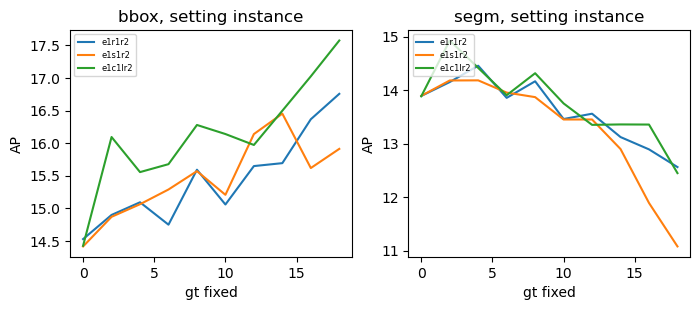

visualize /checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43/0/


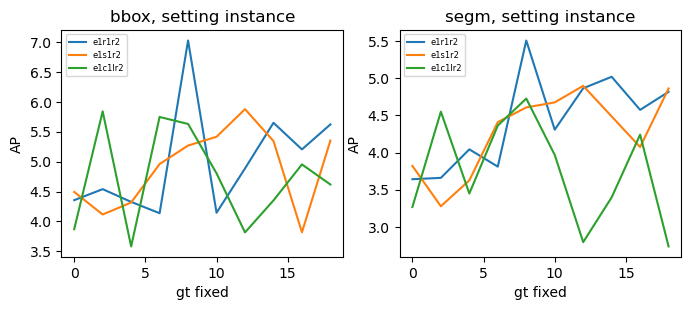

visualize /checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43/2/


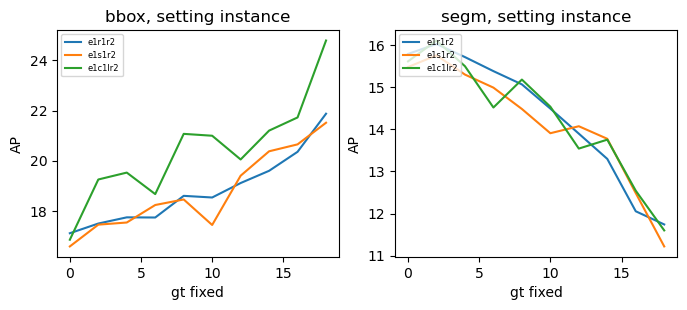

visualize /checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43/6/


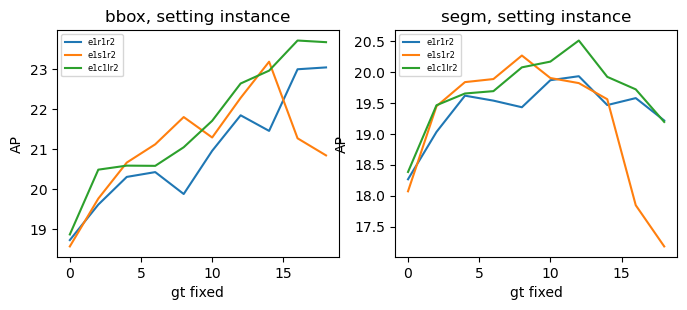

visualize /checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43/8/


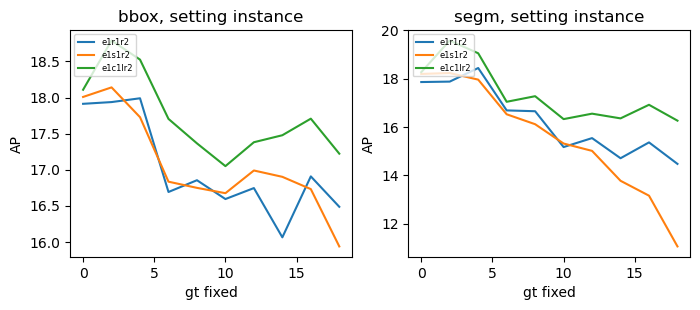

In [426]:
visualize('/checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43', 'instance')
visualize('/checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43/0/', 'instance')
visualize('/checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43/2/', 'instance')
visualize('/checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43/6/', 'instance')
visualize('/checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43/8/', 'instance')

visualize /checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43


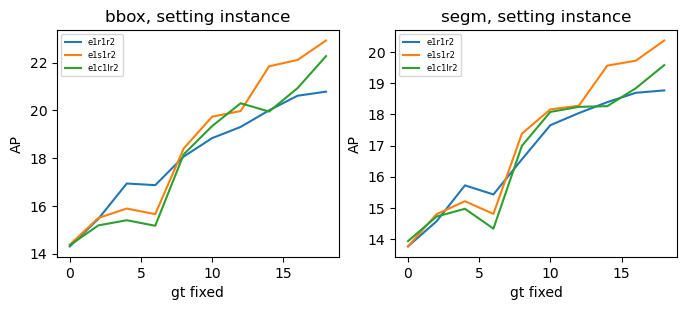

visualize /checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43/0/


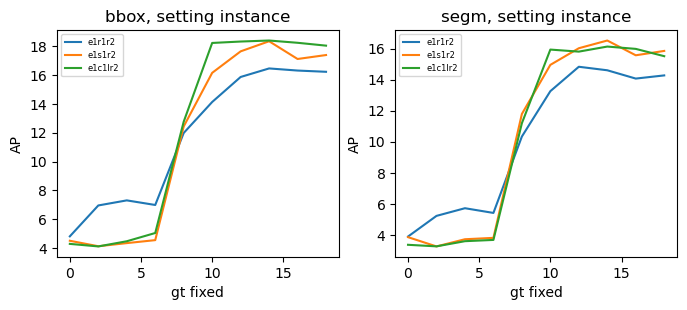

visualize /checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43/2/


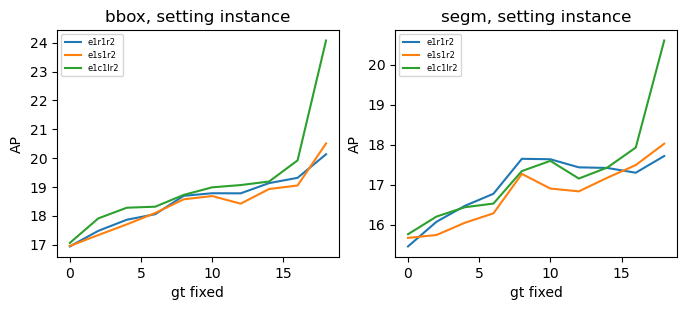

visualize /checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43/6/


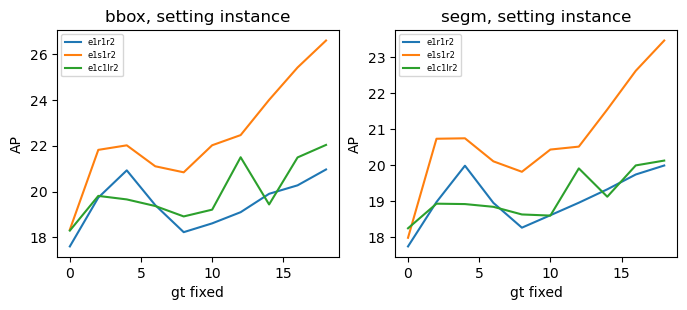

visualize /checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43/8/


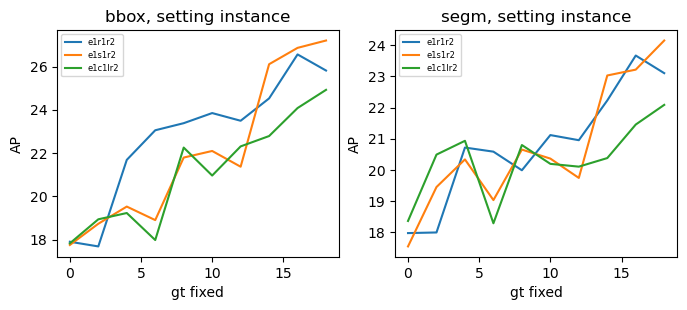

In [428]:
visualize('/checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43', 'instance')
visualize('/checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43/0/', 'instance')
visualize('/checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43/2/', 'instance')
visualize('/checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43/6/', 'instance')
visualize('/checkpoint/apratik/jobs/reexplore/training/31-03-2022/18:47:43/8/', 'instance')